# Concrete compressive strength prediction

Progetto di Programmazione di Applicazioni Data Intensive a.a. 2019/20

Paolo Garroni - Mat. 0000824974 - paolo.garroni2@studio.unibo.it

## Importazione del dataset

Il dataset utilizzato è fornito da [UCI](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength): lo scarichiamo come `dataset.xls` e lo carichiamo nella variabile `data` utilizzando pandas.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import zipfile
import os.path

if not os.path.exists("dataset.xls"):
    from urllib.request import urlretrieve
    urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls", "dataset.xls")
df = pd.read_excel("dataset.xls")

Essendo le etichette presenti di default nel dataset molto lunghe, le sostituiamo con etichette più brevi:

In [3]:
df = df.rename(columns={
    "Cement (component 1)(kg in a m^3 mixture)": "CEMENT",
    "Blast Furnace Slag (component 2)(kg in a m^3 mixture)": "BLAST_FURNACE_SLAG",
    "Fly Ash (component 3)(kg in a m^3 mixture)": "FLY_ASH",
    "Water  (component 4)(kg in a m^3 mixture)": "WATER",
    "Superplasticizer (component 5)(kg in a m^3 mixture)": "SUPERPLASTICIZER",
    "Coarse Aggregate  (component 6)(kg in a m^3 mixture)": "COARSE_AGGREGATE",
    "Fine Aggregate (component 7)(kg in a m^3 mixture)": "FINE_AGGREGATE",
    "Age (day)": "AGE",
    "Concrete compressive strength(MPa, megapascals) ": "CONCRETE_COMPRESSIVE_STRENGTH"
})

Vediamo le prime e ultime righe del dataset, per avere una idea di massima della sua struttura:

In [4]:
df.head(3)

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535


In [5]:
df.tail(3)

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.401235


# Descrizione del problema e comprensione dei dati

L'obiettivo è predire la resistenza a compressione del calcestruzzo in MPa (megapascal), avendo a disposizione la quantità dei componenti e la sua età.

In totale il dataset ha 9 attributi, tutti di tipo quantitativo: 8 variabili di input e 1 variabile di output:

* Cemento (componente 1) - $kg/m^3$
* Scorie di altoforno (componente 2) - $kg/m^3$
* Cenere volante (componente 3) - $kg/m^3$
* Acqua (componente 4) - $kg/m^3$
* Superfluidificante (componente 5) - $kg/m^3$
* Aggregato grosso (componente 6) - $kg/m^3$
* Aggregato fine (componente 7) - $kg/m^3$
* Età - $giorni$
* __Resistenza a compressione del calcestruzzo ($MPa$, Megapascal) - Variabile di output da predire__

L'età è l'unico argomento di tipo discreto (numero di giorni), le rimanenti sono tutte di tipo reale.

# Analisi esplorativa dei dati

## Numero di istanze


In [6]:
print("Sono presenti " + str(df["CONCRETE_COMPRESSIVE_STRENGTH"].count()) + " istanze di osservazioni.")

Sono presenti 1030 istanze di osservazioni.


## Valori mancanti

Non è presente alcun valore mancante:

In [7]:
df.shape[0] - df.count()

CEMENT                           0
BLAST_FURNACE_SLAG               0
FLY_ASH                          0
WATER                            0
SUPERPLASTICIZER                 0
COARSE_AGGREGATE                 0
FINE_AGGREGATE                   0
AGE                              0
CONCRETE_COMPRESSIVE_STRENGTH    0
dtype: int64

## Numero valori distinti di ogni campo

In [8]:
n_unique_values = pd.DataFrame({
    "CEMENT": df['CEMENT'].nunique(),
    "BLAST_FURNACE_SLAG": df['BLAST_FURNACE_SLAG'].nunique(),
    "FLY_ASH": df['FLY_ASH'].nunique(),
    "WATER": df['WATER'].nunique(),
    "SUPERPLASTICIZER": df['SUPERPLASTICIZER'].nunique(),
    "COARSE_AGGREGATE": df['COARSE_AGGREGATE'].nunique(),
    "FINE_AGGREGATE": df['FINE_AGGREGATE'].nunique(),
    "AGE": df['AGE'].nunique(),
    "CONCRETE_COMPRESSIVE_STRENGTH": df['CONCRETE_COMPRESSIVE_STRENGTH'].nunique()
}, index=["n_unique_values"])
n_unique_values

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
n_unique_values,280,187,163,205,155,284,304,14,938


Notiamo che sono presenti un certo numero di valori distinti ripetuti per ogni campo, probabilmente ciò è dovuto al ripetersi di proporzioni standard nei dosaggi che costituiscono la miscela.

Ad ogni modo il numero di valori distinti è troppo elevato per pensare di trattare le variabili come se fossero categoriche (o per predire la variabile di output utilizzando la classificazione piuttosto che la regressione).

Inoltre è verosimile che il modello possa essere utilizzato anche per predire configurazioni di miscela diverse da quelle standard.


## Distribuzioni, medie, stddev, percentili delle variabili di input nel dataset

In [9]:
df.describe()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


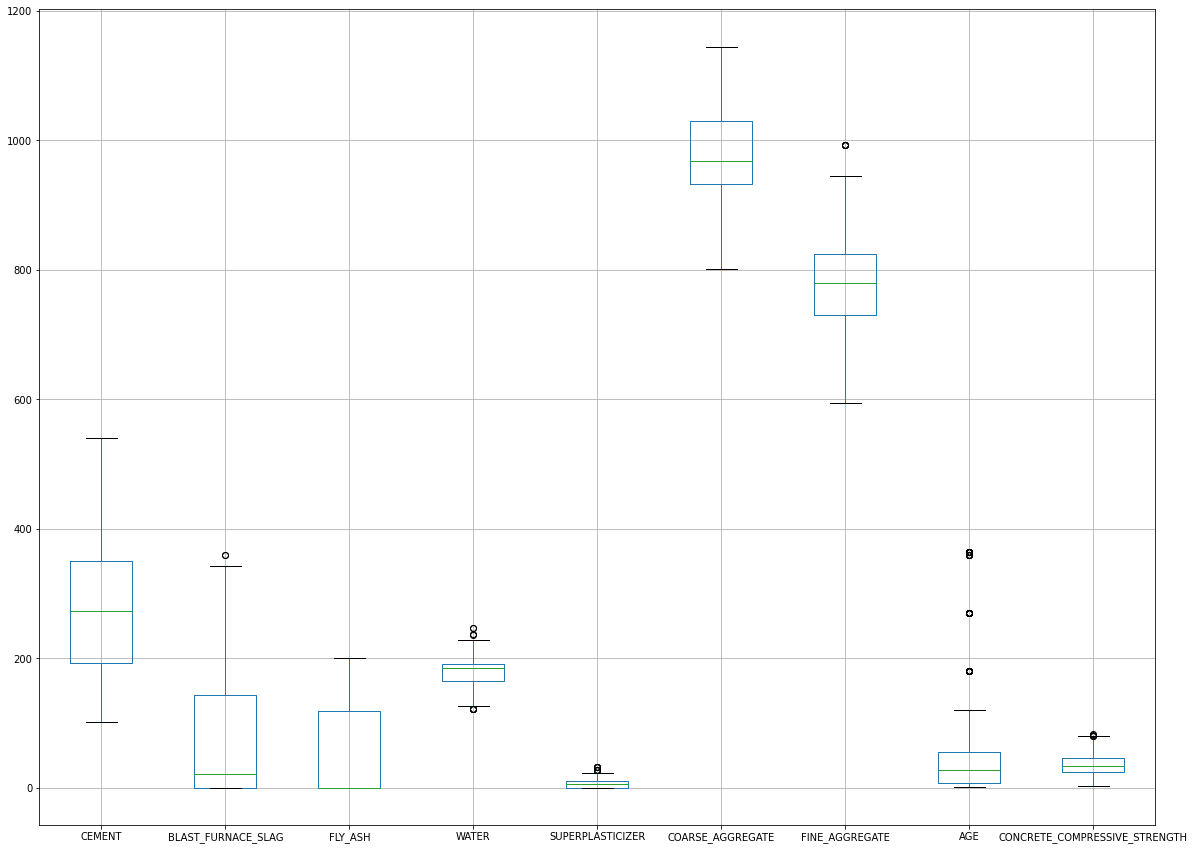

In [10]:
df.boxplot(figsize=(20,15))

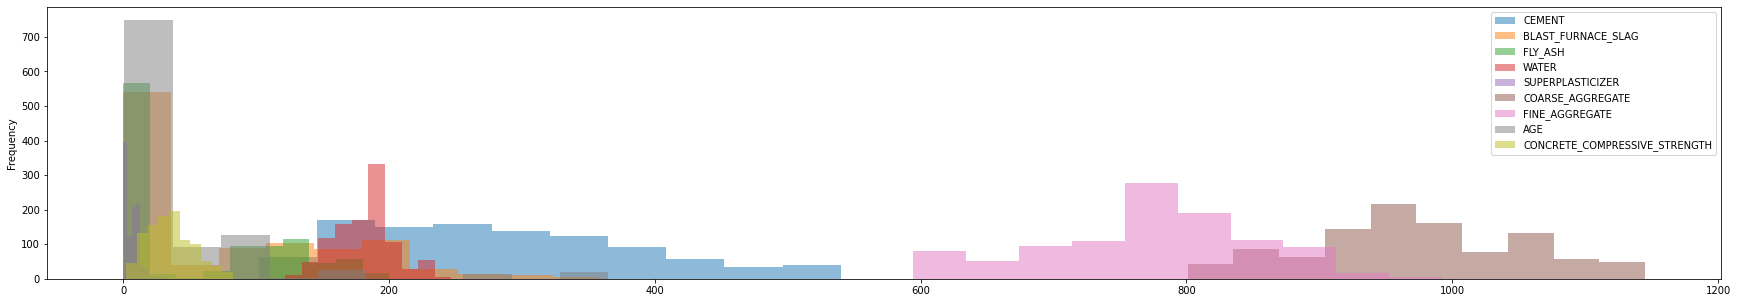

In [11]:
df["CEMENT"].plot.hist(legend=True, figsize=(30,5), alpha=0.5)
df["BLAST_FURNACE_SLAG"].plot.hist(legend=True, alpha=0.5)
df["FLY_ASH"].plot.hist(legend=True, alpha=0.5)
df["WATER"].plot.hist(legend=True, alpha=0.5)
df["SUPERPLASTICIZER"].plot.hist(legend=True, alpha=0.5)
df["COARSE_AGGREGATE"].plot.hist(legend=True, alpha=0.5)
df["FINE_AGGREGATE"].plot.hist(legend=True, alpha=0.5)
df["AGE"].plot.hist(legend=True, alpha=0.5)
df["CONCRETE_COMPRESSIVE_STRENGTH"].plot.hist(legend=True, alpha=0.5)

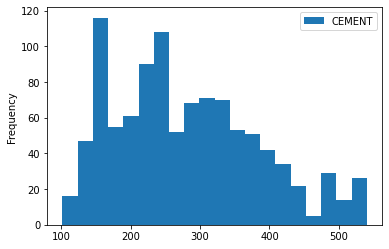

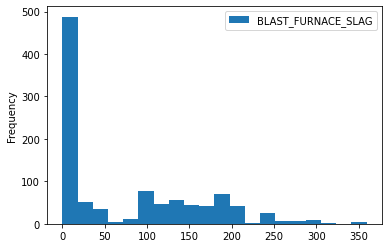

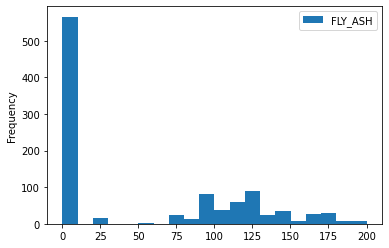

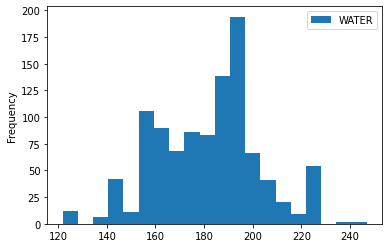

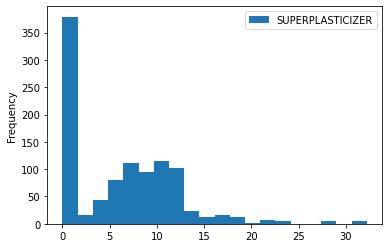

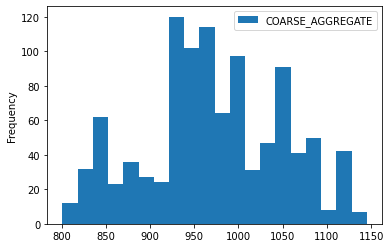

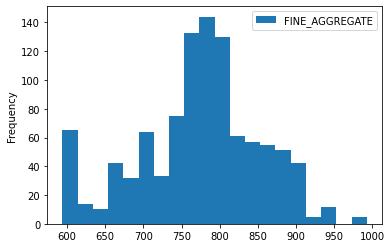

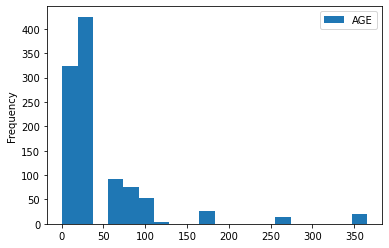

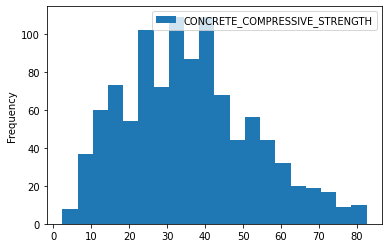

In [12]:
df["CEMENT"].plot.hist(bins=20, legend=True)
plt.show(block=True)
df["BLAST_FURNACE_SLAG"].plot.hist(bins=20, legend=True)
plt.show(block=True)
df["FLY_ASH"].plot.hist(bins=20, legend=True)
plt.show(block=True)
df["WATER"].plot.hist(bins=20, legend=True)
plt.show(block=True)
df["SUPERPLASTICIZER"].plot.hist(bins=20, legend=True)
plt.show(block=True)
df["COARSE_AGGREGATE"].plot.hist(bins=20, legend=True)
plt.show(block=True)
df["FINE_AGGREGATE"].plot.hist(bins=20, legend=True);
plt.show(block=True)
df["AGE"].plot.hist(bins=20, legend=True);
plt.show(block=True)
df["CONCRETE_COMPRESSIVE_STRENGTH"].plot.hist(bins=20, legend=True);

## Grafici a dispersione e correlazione tra variabili


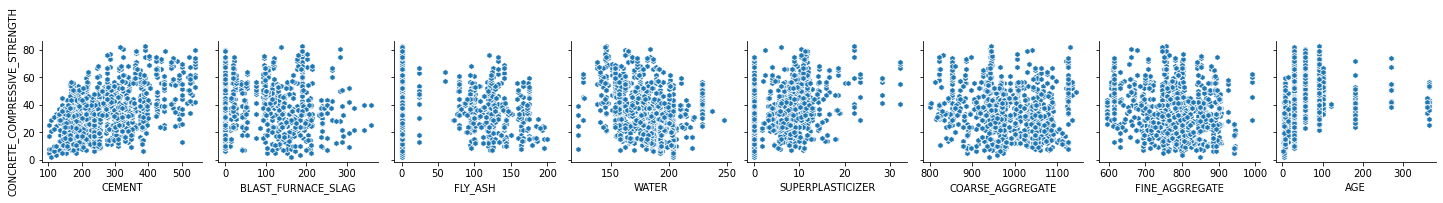

In [16]:
import seaborn as sns
sns.pairplot(df,markers="h", 
             y_vars="CONCRETE_COMPRESSIVE_STRENGTH", 
             x_vars=["CEMENT", "BLAST_FURNACE_SLAG", "FLY_ASH", "WATER", "SUPERPLASTICIZER", "COARSE_AGGREGATE", "FINE_AGGREGATE", "AGE"])
plt.show()

A prima vista, dai grafici a dispersione, le variabili sembrano essere piuttosto indipendenti tra loro, non sembrano esserci correlazioni forti. 

Le uniche visibili, anche se deboli, sembrano essere:

* CEMENT-CONCRETE_COMPRESSIVE_STRENGTH (diretta) - Aumentando la quantità di cemento (CEMENT) aumenta anche la resistenza alla compressione del calcestruzzo (CONCRETE_COMPRESSIVE_STRENGTH). Essendo quest'ultima la variabile di output da predire, questa correlazione ci indica che molto probabilmente la quantità di cemento sarà una feature importante nel modello.


## Calcolo degli indici di correlazione di Spearman

Per avere una idea quantitativa delle correlazioni tra variabili già notate in precedenza calcoliamo gli indici di correlazione di Spearman, che a differenza di Pearson consente di individuare correlazioni non lineari e non richiede che le variabili abbiano una distribuzione normale.

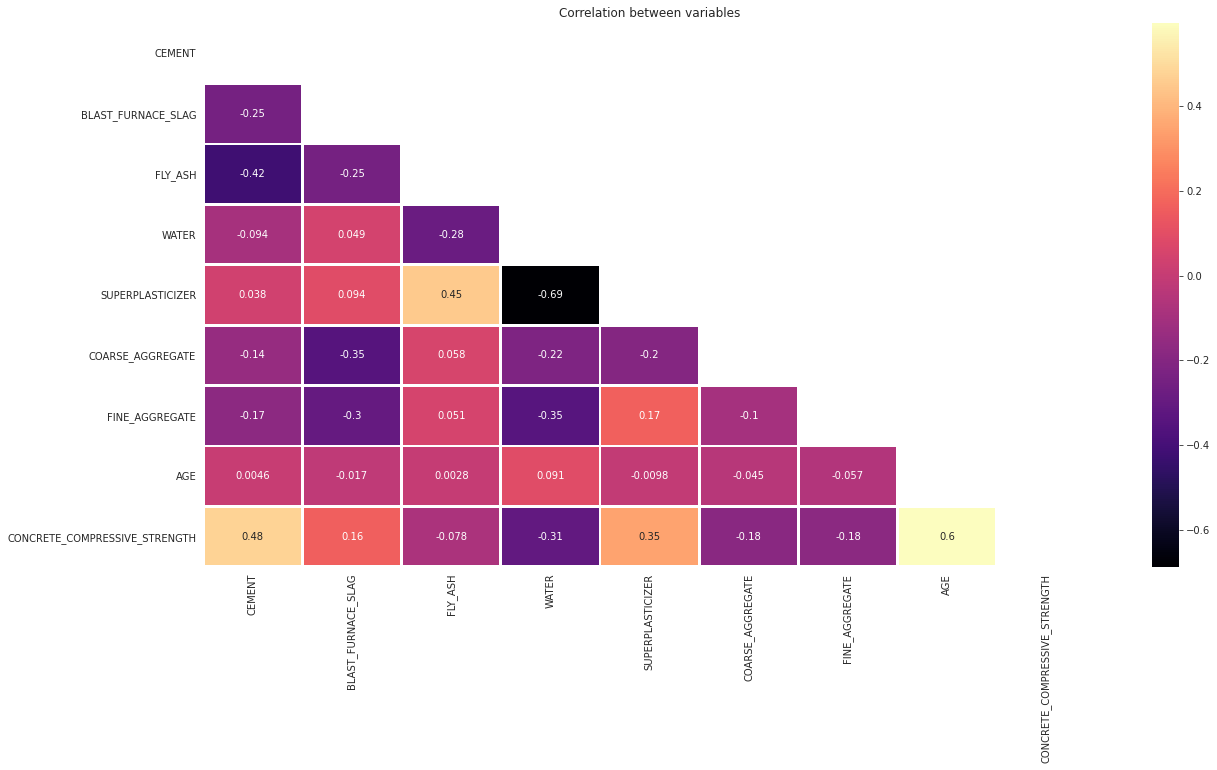

In [18]:
from sklearn import preprocessing
cor = df.corr(method="spearman")
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,10))
with sns.axes_style("white"):
    sns.heatmap(cor,annot=True,linewidth=2,
                mask = mask,cmap="magma")
plt.title("Correlation between variables")
plt.show()

Nell'ultima riga notiamo che AGE, CEMENT e SUPERPLASTICIZER sono le variabili maggiormente correlate alla variabile output da predire, anche se non si tratta di una correlazione forte: ciò ci indica che probabilmente esse saranno feature importanti nel modello.

Un altro aspetto che si può notare è che tra WATER e SUPERPLASTICIZER esiste una correlazione inversa (come era plausibile supporre), anche in questo caso non particolarmente forte.

## Indagine sulla rilevanza delle feature con standardizzazione e regressione Lasso

Per indagare l'importanza delle varie feature effettuiamo delle prove di regressione Lasso.

### Definizione delle funzioni di misura d'errore

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

### Creazione di training-set e validation set con Holdout 70/30

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="CONCRETE_COMPRESSIVE_STRENGTH")
y = df["CONCRETE_COMPRESSIVE_STRENGTH"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

### Regressione lineare

Proviamo inizialmente la regressione lineare utilizzando tutte le features per avere un riferimento di accuratezza con cui confrontare quella ottenuta nella regressione Lasso.


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
model.fit(X_train, y_train)
print(pd.Series(model.named_steps["regr"].coef_, X.columns).sort_values(ascending=False))
print("\n")
print_eval(X_val, y_val, model)

CEMENT                13.287582
BLAST_FURNACE_SLAG     9.928057
AGE                    7.173246
FLY_ASH                5.593067
FINE_AGGREGATE         2.814674
SUPERPLASTICIZER       2.529267
COARSE_AGGREGATE       2.124094
WATER                 -2.013452
dtype: float64


   Mean squared error: 113.18
       Relative error: 32.27772%
R-squared coefficient: 0.59063


### Regressione Lasso con alpha=1

Con `alpha` = 1 si annullano tre feature con un peggioramento nell'accuratezza:

In [22]:
from sklearn.linear_model import Lasso

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
model.fit(X_train, y_train)
print(pd.Series(model.named_steps["regr"].coef_, X.columns).sort_values(ascending=False))
print("\n")
print_eval(X_val, y_val, model)

CEMENT                7.305116
AGE                   5.572454
BLAST_FURNACE_SLAG    3.882692
SUPERPLASTICIZER      3.756024
FINE_AGGREGATE       -0.000000
COARSE_AGGREGATE     -0.000000
FLY_ASH               0.000000
WATER                -2.713206
dtype: float64


   Mean squared error: 128.85
       Relative error: 38.16203%
R-squared coefficient: 0.53397


### Regressione Lasso con alpha=0.15

Con alpha= 0.15 si annullano due feature e otteniamo una accuratezza simile a quella ottenuta nella regressione lineare. 

In [23]:
from sklearn.linear_model import Lasso

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=0.15))
])
model.fit(X_train, y_train)
print(pd.Series(model.named_steps["regr"].coef_, X.columns).sort_values(ascending=False))
print("\n")
print_eval(X_val, y_val, model)

CEMENT                10.085351
AGE                    6.853020
BLAST_FURNACE_SLAG     6.780600
FLY_ASH                2.874158
SUPERPLASTICIZER       2.476017
FINE_AGGREGATE         0.000000
COARSE_AGGREGATE       0.000000
WATER                 -4.027498
dtype: float64


   Mean squared error: 113.05
       Relative error: 33.08747%
R-squared coefficient: 0.59111


Con la regressione Lasso abbiamo verificato che rimuovendo le features COARSE_AGGREGATE e FINE_AGGREGATE l'accuratezza non subisce peggioramenti rilevanti. 

Visto il numero non elevato di istanze di osservazioni è desiderabile mantenere il minor numero di feature possibile purché la loro rimozione non determini una perdita rilevante di accuratezza, in modo da poter aumentare il grado nelle trasformazioni polinomiali senza incorrere nel problema dell'elevata dimensionalità.

Scegliamo quindi di rimuovere COARSE_AGGREGATE e FINE_AGGREGATE dalle feature considerate per la regressione:

In [24]:
X = X.drop(columns=["COARSE_AGGREGATE", "FINE_AGGREGATE"])

# Generazione di diversi modelli di regressione

Generiamo ora diversi modelli di regressione utilizzando nested-cross-validation e grid-search. 

In particolare con Grid search ricercheremo gli iperparametri migliori nella cross-validation interna, mentre con la cross validation esterna addestreremo il modello e ne stimeremo l'accuratezza a regime.

I modelli che genereremo sono:

* Modelli polinomiali non-kernel
  * Regressione polinomiale
  * Regressione Ridge (regolarizzazione L2)
  * Regressione ElasticNet (regolarizzazione L1 + L2)
* Modelli polinomiali kernel
  * Regressione Kernel Ridge polinomiale
  * Regressione Kernel Ridge RBF (Radial Basis Function)

## Definizione della funzione nested-cross-validation


In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from IPython.display import display, HTML

def nested_cv(X, y, model, grid):
  outer_cv = KFold(3, shuffle=True, random_state=42)
  inner_cv = KFold(5, shuffle=True, random_state=42)
  scores = []
  best_params = {}
  for train_indices, val_indices in outer_cv.split(X, y):
      gs = GridSearchCV(model, grid, cv=inner_cv)
      gs.fit(X.iloc[train_indices], y.iloc[train_indices])
      score = gs.score(X.iloc[val_indices], y.iloc[val_indices])
      scores.append(score)
      print("R^2 SCORE=" + str(score) + " - HYPER-PARAMS:" + str(gs.best_params_))
      if (score == max(scores)) :
          best_params = gs.best_params_
  print("\nMEAN R^2 SCORE: " + str(sum(scores) / len(scores)))
  print("BEST HYPER-PARAMS: " + str(best_params))

  return

## Modelli polinomiali non-kernel


### Regressione polinomiale semplice

Come primo modello generiamo una regressione polinomiale semplice. 

Impostiamo la grid per individuare gli iperparametri migliori come segue: 

* grado del polinomio compreso in `list(range(1, 5))`



In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  LinearRegression())
])
grid = {
    "poly__degree": list(range(1, 5))
}
nested_cv(X, y, model, grid)

R^2 SCORE=0.8355707250124036 - HYPER-PARAMS:{'poly__degree': 3}
R^2 SCORE=0.8421068395865257 - HYPER-PARAMS:{'poly__degree': 3}
R^2 SCORE=0.8616412040885519 - HYPER-PARAMS:{'poly__degree': 3}

MEAN R^2 SCORE: 0.8464395895624938
BEST HYPER-PARAMS: {'poly__degree': 3}


L'iperparametro risultato migliore è il grado 3.

Definiamo quindi una pipeline per il modello:

In [27]:
poly = Pipeline([
    ("scale", StandardScaler()),
    ("poly",  PolynomialFeatures(degree=3, include_bias=False)),
    ("regr", LinearRegression())
])

### Regressione Ridge (regolarizzazione L2)

Proviamo ora una regressione polinomiale Ridge (regolarizzazione L2).

Impostiamo la grid per individuare gli iperparametri migliori come segue: 

* grado del polinomio compreso in `list(range(1, 5))`
* `alpha` compreso in `[0.3, 0.8, 1, 3, 5, 10, 20]`


In [28]:
from sklearn.linear_model import Ridge

model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge())
])
grid = {
    "poly__degree": list(range(1, 5)),
    "regr__alpha": [0.3, 0.8, 1, 3, 5, 10, 20]
}
nested_cv(X, y, model, grid)

R^2 SCORE=0.8348107775981576 - HYPER-PARAMS:{'poly__degree': 3, 'regr__alpha': 0.3}
R^2 SCORE=0.8355297710817703 - HYPER-PARAMS:{'poly__degree': 3, 'regr__alpha': 0.3}
R^2 SCORE=0.8438579351227135 - HYPER-PARAMS:{'poly__degree': 4, 'regr__alpha': 3}

MEAN R^2 SCORE: 0.8380661612675472
BEST HYPER-PARAMS: {'poly__degree': 4, 'regr__alpha': 3}


Gli iper-parametri risultati migliori sono il grado 4 e alpha=3.

Definiamo quindi una pipeline con tali iperparametri:

In [29]:
ridge = Pipeline([
    ("poly",  PolynomialFeatures(degree=4, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge(alpha=3))
])

### ElasticNet (Regolarizzazione L1 + L2)

Proviamo ora una regressione polinomiale ElasticNet (regolarizzazione L1 e L2).

Impostiamo la grid per individuare gli iperparametri migliori come segue: 

* grado del polinomio compreso in `list(range(1, 5))`
* `alpha` compreso in `[0.1, 0.5, 1, 3, 5]`
* `l1_ratio` compreso in `[0.1, 0.5, 0.9]`.


In [30]:
from sklearn.linear_model import ElasticNet
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  ElasticNet(normalize=True))
])
grid = {
    "poly__degree": list(range(1, 5)),
    "regr__l1_ratio": [0.1, 0.5, 0.9],
    "regr__alpha": [0.1, 0.5, 1, 3, 5]
}
nested_cv(X, y, model, grid)

R^2 SCORE=0.36826853573919394 - HYPER-PARAMS:{'poly__degree': 4, 'regr__alpha': 0.1, 'regr__l1_ratio': 0.9}
R^2 SCORE=0.47891450129678703 - HYPER-PARAMS:{'poly__degree': 4, 'regr__alpha': 0.1, 'regr__l1_ratio': 0.9}
R^2 SCORE=0.40214427766002525 - HYPER-PARAMS:{'poly__degree': 4, 'regr__alpha': 0.1, 'regr__l1_ratio': 0.9}

MEAN R^2 SCORE: 0.41644243823200205
BEST HYPER-PARAMS: {'poly__degree': 4, 'regr__alpha': 0.1, 'regr__l1_ratio': 0.9}


In questo caso i risultati sono nettamente peggiori, pertanto scartiamo Elastic Net come possibile modello.

## Modelli kernel


### Kernel Ridge polinomiale

Proviamo ora una regressione Kernel Ridge polinomiale.

Impostiamo la grid per individuare gli iperparametri migliori come segue: 

* grado del polinomio compreso in `list(range(1, 5))`
* `alpha` compreso in `[0.2, 0.6, 1, 5, 10, 20]`


In [31]:
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="poly")),
])
grid = {
    "regr__degree": list(range(1, 5)), 
    "regr__alpha":  [0.3, 0.8, 1, 3, 5, 10, 20],
}
nested_cv(X, y, model, grid)

R^2 SCORE=0.8701066437000716 - HYPER-PARAMS:{'regr__alpha': 0.8, 'regr__degree': 4}
R^2 SCORE=0.8500413775603487 - HYPER-PARAMS:{'regr__alpha': 0.3, 'regr__degree': 4}
R^2 SCORE=0.8817279304057477 - HYPER-PARAMS:{'regr__alpha': 0.8, 'regr__degree': 4}

MEAN R^2 SCORE: 0.8672919838887226
BEST HYPER-PARAMS: {'regr__alpha': 0.8, 'regr__degree': 4}


Gli iper-parametri risultati migliori sono il grado 4 e alpha=0.8.

Definiamo quindi una pipeline con tali iperparametri:

In [32]:
kernelRidge_poly = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="poly", degree=4, alpha=0.8)),
])

## Kernel Ridge Radial Basis Function

Proviamo ora una regressione Kernel Ridge RBF - Radial Basis Function.

Impostiamo la grid per individuare gli iperparametri migliori come segue: 

* `gamma` compreso in `[0.001, 0.01, 0.1]`
* `alpha` compreso in `np.logspace(-3, 2, 6)`


In [33]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="rbf"))
])
grid = {
    "regr__gamma": [0.001, 0.01, 0.1],
    "regr__alpha": np.logspace(-3, 2, 6)
}
nested_cv(X, y, model, grid)

R^2 SCORE=0.8673540149049687 - HYPER-PARAMS:{'regr__alpha': 0.01, 'regr__gamma': 0.1}
R^2 SCORE=0.8758298119572333 - HYPER-PARAMS:{'regr__alpha': 0.01, 'regr__gamma': 0.1}
R^2 SCORE=0.8811958906662182 - HYPER-PARAMS:{'regr__alpha': 0.01, 'regr__gamma': 0.1}

MEAN R^2 SCORE: 0.87479323917614
BEST HYPER-PARAMS: {'regr__alpha': 0.01, 'regr__gamma': 0.1}


Gli iper-parametri risultati migliori sono gamma=0.1 e alpha=0.01.

Definiamo quindi una pipeline con tali iperparametri.

In [34]:
kernelRidge_rbf = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="rbf", alpha=0.01, gamma=0.1))
])

# Modelli migliori a confronto

Ora che per ciascun modello sono stati individuati gli iperparametri migliori vogliamo addestrare e validare i singoli modelli con tali iperparametri e confrontare la capacità dei modelli di generalizzazione (ovvero di prevedere i dati sconosciuti del validation set).

Per far ciò eseguiamo una K-fold cross validation per ogni modello e calcoliamo la media delle accuratezze $R^2$ dei k modelli e la loro deviazione standard.

Nella precedente nested-cross-validation tutti i modelli testati, escluso ElasticNet, hanno ottenuto accuratezze molto ravvicinate e paragonabili, e quindi verranno presi in esame.

In [35]:
from sklearn.model_selection import KFold, cross_validate
from math import sqrt

kf = KFold(10, shuffle=True, random_state=42)

def cross_validate_results(model, name, results=None):
    if results is None: results = pd.DataFrame(columns=["CV-score-mean", "CV-score-std"])
    cv_results = cross_validate(model, X, y, cv=kf)
    mean_score = cv_results["test_score"].mean()
    std_score = cv_results["test_score"].std()
    results = results.append(pd.DataFrame(index=[name], data={
      "CV-score-mean": mean_score,
      "CV-score-std": std_score,
    }))
    return results

In [36]:
results = cross_validate_results(poly, "poly")
results = cross_validate_results(ridge, "ridge", results)
results = cross_validate_results(kernelRidge_poly, "kernelRidge_poly", results)
results = cross_validate_results(kernelRidge_rbf, "kernelRidge_rbf", results)
results

,CV-score-mean,CV-score-std
poly,0.846404,0.041108
ridge,0.849785,0.031587
kernelRidge_poly,0.871941,0.035000
kernelRidge_rbf,0.872657,0.040558


I modelli hanno capacità di generalizzazione simile tra loro. Notiamo che i modelli che utilizzano Kernel hanno avuto un risultato lievemente migliore.

## Intervalli di confidenza dell'accuratezza al 95%

Calcoliamo ora, per ogni modello preso in esame, le misure di errore, l'accuratezza e i suoi intervalli di confidenza al 95%.

Visto che l'accuratezza calcolata è dipendente dal validation set specifico utilizzato e dalle sue dimensioni, calcolare l'intervallo di confidenza ci consente di stabilire un intervallo di accuratezza entro il quale possiamo assumere si troverà l'accuratezza "reale" (cioè un range di accuratezza assumibile con un certo grado di certezza, stabilito in questo caso al 95%).

In [37]:
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

def evaluate(model, name, results=None):
  if results is None: results = pd.DataFrame(
      columns=["MAE", "MSE", "REL_ERR", "R_SQUARED", "R_SQUARED_CONF_INT_95%"])
  model.fit(X_train, y_train)
  preds_val = model.predict(X_val)
  results = results.append(
    pd.DataFrame(index=[name], data={
      "MAE": mean_absolute_error(y_val, preds_val),
      "MSE": mean_squared_error(y_val, preds_val), 
      "REL_ERR": relative_error(y_val, preds_val), 
      "R_SQUARED": r2_score(y_val, preds_val),
      "R_SQUARED_CONF_INT_95%": str(model_conf_interval(model, X_val, y_val))
     }))
  return results

In [38]:
results = evaluate(poly, "poly")
results = evaluate(ridge, "ridge", results)
results = evaluate(kernelRidge_poly, "kernelRidge_poly", results)
results = evaluate(kernelRidge_rbf, "kernelRidge_rbf", results)
results

,MAE,MSE,REL_ERR,R_SQUARED,R_SQUARED_CONF_INT_95%
poly,5.022984,45.461512,0.168620,0.835571,"(0.7927360945301256, 0.8709934666075037)"
ridge,4.967294,41.429202,0.168749,0.850155,"(0.8085810202639311, 0.883995253493384)"
kernelRidge_poly,4.454978,35.912999,0.152353,0.870107,"(0.8304541724725459, 0.90158441697261)"
kernelRidge_rbf,4.365640,36.674048,0.145874,0.867354,"(0.8274216059688869, 0.8991725243326004)"


Anche per quanto riguarda le misure di errore e gli intervalli di confidenza al 95% notiamo che i risultati ottenuti sono simili tra i vari modelli.

Notiamo che i modelli che utilizzano Kernel hanno avuto un risultato di poco migliore.

## La differenza di accuratezza tra i modelli è significativa?

Ci chiediamo ora se sia significativa la differenza di accuratezza tra i vari modelli: per verificarlo calcoliamo l'intervallo di confidenza della differenza tra le accuratezze. 

Se l'intervallo ottenuto non include lo zero possiamo assumere, con una confidenza del 95%, che la differenza tra le accuratezze sia significativa. Viceversa, potremo assumere che non lo sia.


In [39]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

Per esempio, prendiamo un modello kernel (che abbiamo visto avere tra i migliori risultati) e un modello che assumiamo abbia accuratezza significativamente minore: la regressione lineare.

In [40]:
linear = Pipeline([
    ("regr", LinearRegression())
])
evaluate(linear, "linear")

,MAE,MSE,REL_ERR,R_SQUARED,R_SQUARED_CONF_INT_95%
linear,8.375374,111.626696,0.323786,0.596259,"(0.5436229421216694, 0.6467680597686007)"


In [41]:
model_diff_interval(kernelRidge_poly, linear, X_val, y_val)

(0.2109959057122241, 0.33670027749068604)

L'intervallo non include lo zero, quindi con una confidenza del 95% possiamo dire che la differenza di accuratezza è significativa: il modello Kernel-ridge-poly è significativamente migliore del modello lineare.


Scegliamo ora di confrontare il migliore tra i modelli kernel (Kernel ridge polinomiale) e il modello polinomiale semplice.

La differenza di accuratezza risultata nelle fasi precedenti è significativa?

In [42]:
model_diff_interval(kernelRidge_poly, poly, X_val, y_val)

(-0.0183448327912435, 0.08741667016657556)

L'intervallo calcolato include lo zero, quindi la differenza tra le accuratezze misurate non è significativa con una confidenza del 95%. 

# Conclusioni

I modelli generati hanno in generale risultati di accuratezza simili.

I modelli kernel hanno mostrato una accuratezza lievemente maggiore rispetto ai modelli non-kernel, ma questa differenza non si è rivelata essere significativa con il livello di confidenza richiesto.

Il modello polinomiale semplice quindi è preferibile in quanto di complessità inferiore e quindi meglio comprensibile e spiegabile, per esempio attraverso l'analisi dei coefficienti delle varie features.

## Interpretazione dei coefficienti del modello polinomiale 

In [43]:
def print_parameters(model, from_feature, to_feature, figsize):
  features = ridge.named_steps["poly"].get_feature_names(X_train.columns)[from_feature:to_feature]
  coefficients = model.named_steps["regr"].coef_
  pd.Series(coefficients[from_feature:to_feature], features).plot.bar(figsize=figsize)

Esaminando i coefficienti delle features di primo, secondo e terzo grado possiamo dare una interpretazione del peso delle varie feature e delle loro correlazioni:

In [44]:
print("Sono presenti " + str(len(poly.named_steps["regr"].coef_)) + " feature in totale.")

Sono presenti 83 feature in totale.


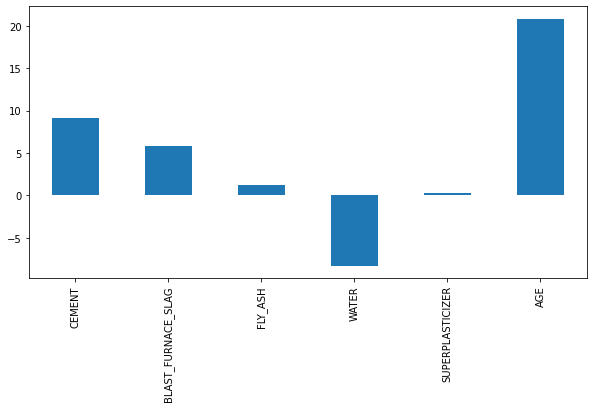

In [45]:
print_parameters(poly, 0, 6, (10,5))

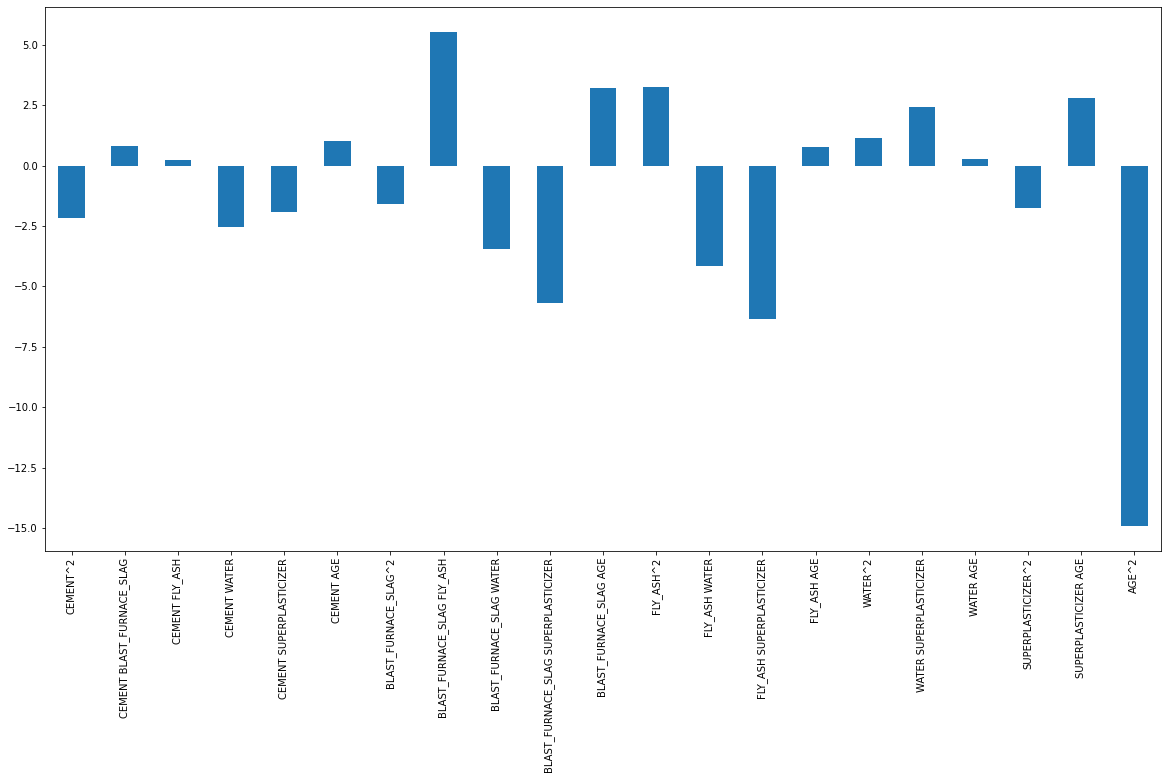

In [46]:
print_parameters(poly, 6, 27, (20,10))

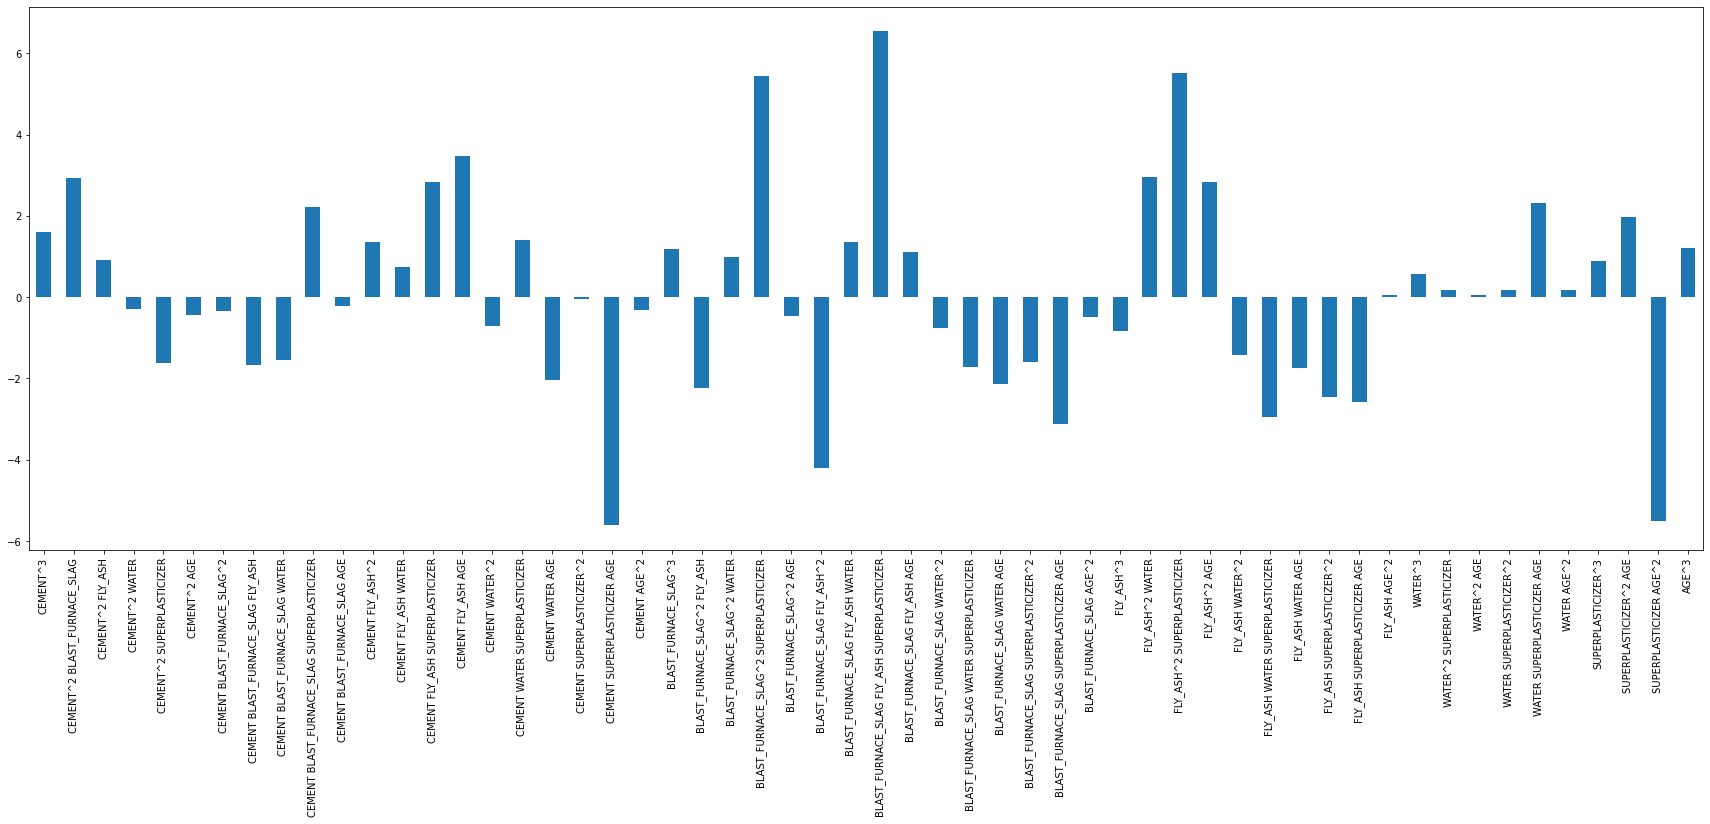

In [47]:
print_parameters(poly, 27, 83, (30,10))

## Analisi dell'efficacia del modello su dati ignoti (validation set)

Tracciando lo scatter-plot dei valori da predire nel validation set insieme a quelli effettivamente predetti dal modello possiamo avere un riscontro visivo del comportamento del modello con dati ignoti.

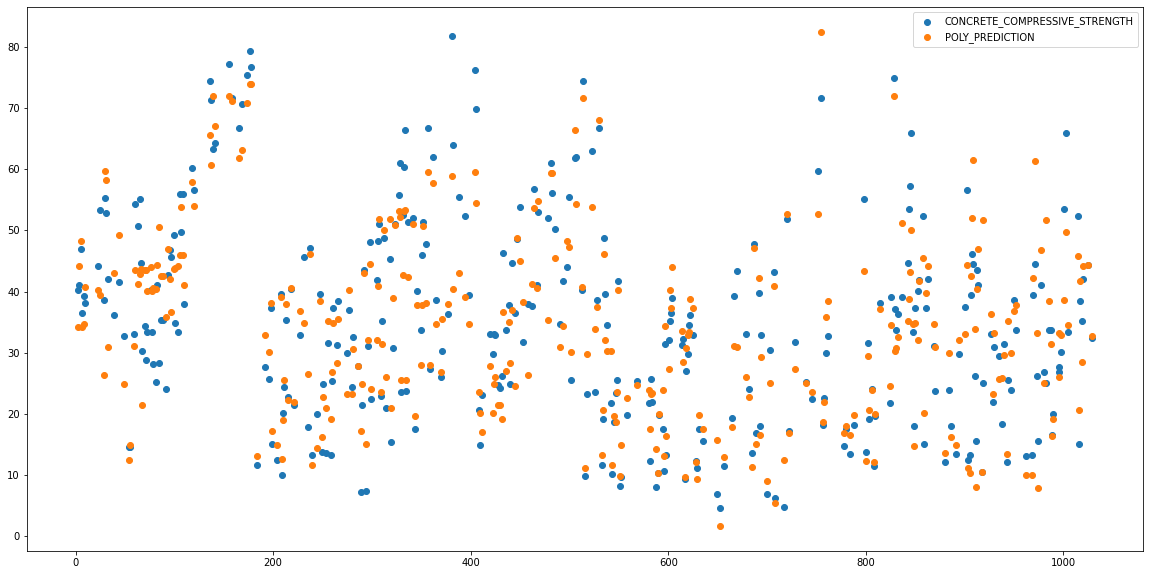

In [48]:
y_preds = poly.predict(X_val)
plt.figure(figsize=(20,10))
plt.scatter(y_val.index, y_val, label="CONCRETE_COMPRESSIVE_STRENGTH")
plt.scatter(y_val.index, y_preds, label="POLY_PREDICTION")
plt.legend()

Analizziamo ora la distribuzione dell'errore assoluto nelle previsioni:


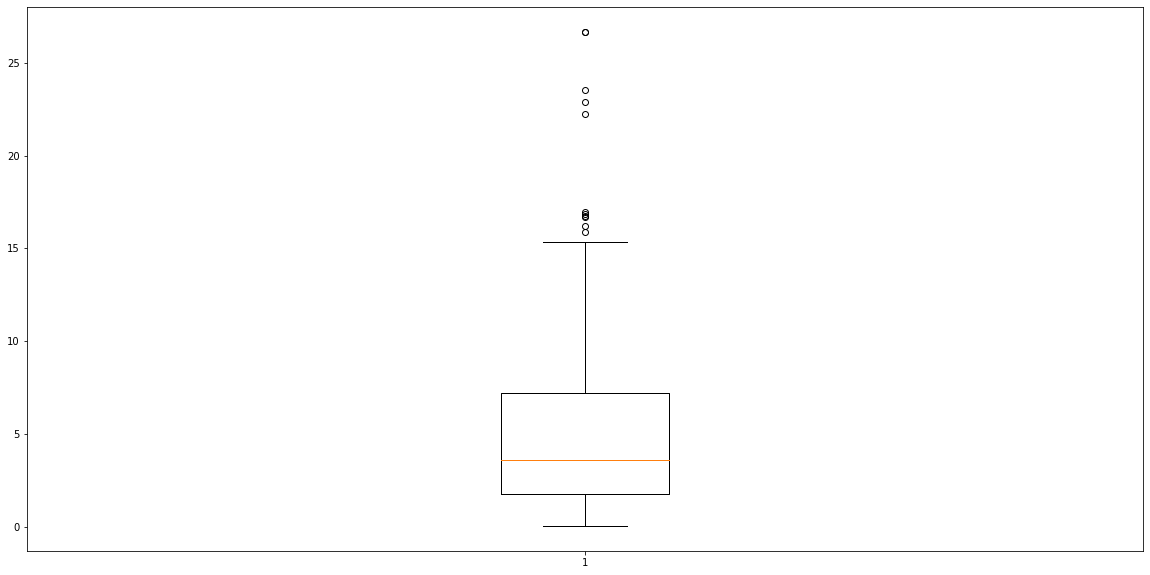

In [49]:
abs_errors = abs(y_val - y_preds)

plt.figure(figsize=(20,10))
bp_values = plt.boxplot(abs_errors)

(array([130.,  91.,  56.,  31.,  18.,   8.,   5.,   0.,   3.,   2.]),
 array([2.61513255e-02, 2.69026961e+00, 5.35438790e+00, 8.01850619e+00,
        1.06826245e+01, 1.33467428e+01, 1.60108611e+01, 1.86749793e+01,
        2.13390976e+01, 2.40032159e+01, 2.66673342e+01]),
 <a list of 10 Patch objects>)

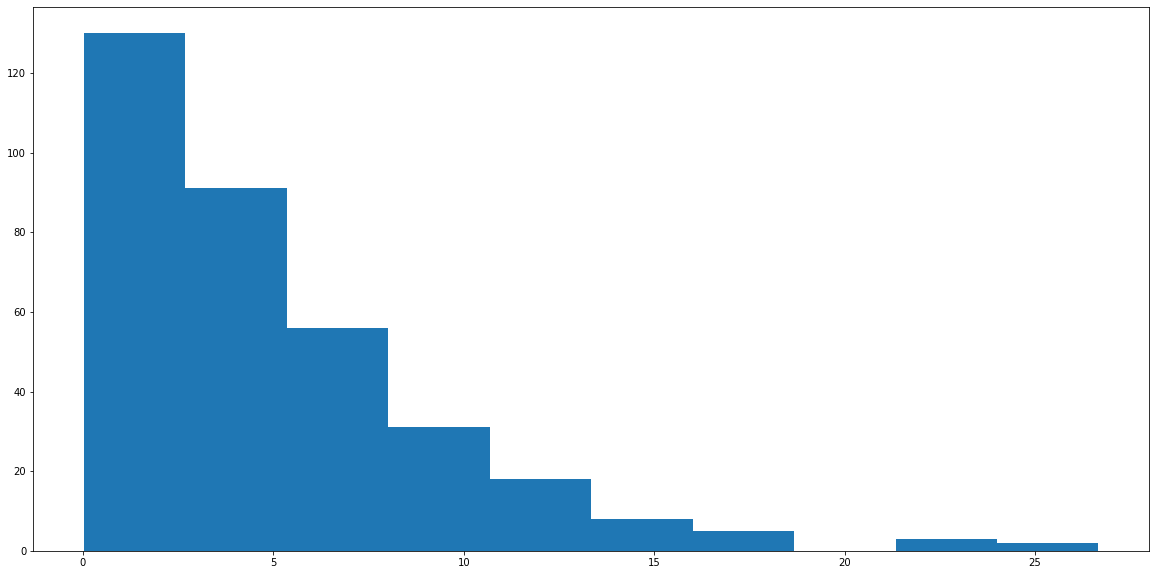

In [51]:
plt.figure(figsize=(20,10))
plt.hist(abs(y_val - y_preds))

In [50]:
abs_errors.describe()

count    344.000000
mean       5.022984
std        4.504457
min        0.026151
25%        1.744099
50%        3.604264
75%        7.202579
max       26.667334
Name: CONCRETE_COMPRESSIVE_STRENGTH, dtype: float64

Ci rendiamo conto che il modello è in grado, fornendo istanze ignote di miscele di componenti, di predire la forza di resistenza a compressione del calcestruzzo piuttosto efficacemente:

* L'errore assoluto medio (MAE) è $\simeq 5 MPa$ (Megapascal), con una deviazione standard di $\simeq 4.5 MPa$
* La metà delle istanze viene predetta con un errore assoluto tra $\simeq 1.7 MPa$ e $\simeq 7.2 MPa$ 
* L'errore assoluto massimo è $\simeq 27 MPa$.  